## Chapter 2 from Bjornstad (2018): original code in R

### Libraries

In [1]:
using RCall
using DataFrames
using Plots

In [2]:
@rlibrary epimdr

### SIR model

Define the model.

In [2]:
sirmod=function(t, y, parms){
   #Pull state variables from y vector
   S=y[1]
   I=y[2]
   R=y[3]
   #Pull parameter values from parms vector
   beta=parms["beta"]
   mu=parms["mu"]
   gamma=parms["gamma"]
   N=parms["N"]
   #Define equations
   dS = mu * (N  - S)  - beta * S * I / N
   dI = beta * S * I / N - (mu + gamma) * I
   dR = gamma * I - mu * R
   res=c(dS, dI, dR)
   #Return list of gradients
   list(res)
 }

Set the time, parameters and initial conditions.

In [3]:
times  = seq(0, 26, by=1/10)
parms  = c(mu = 0, N = 1, beta =  2, gamma = 1/2)
start = c(S=0.999, I=0.001, R = 0)

Run the model.

In [4]:
out = ode(y = start, times = times, func = sirmod, 
     parms = parms)
out=as.data.frame(out)
head(round(out, 3))

time,S,I,R
0.0,0.999,0.001,0
0.1,0.999,0.001,0
0.2,0.999,0.001,0
0.3,0.998,0.002,0
0.4,0.998,0.002,0
0.5,0.998,0.002,0


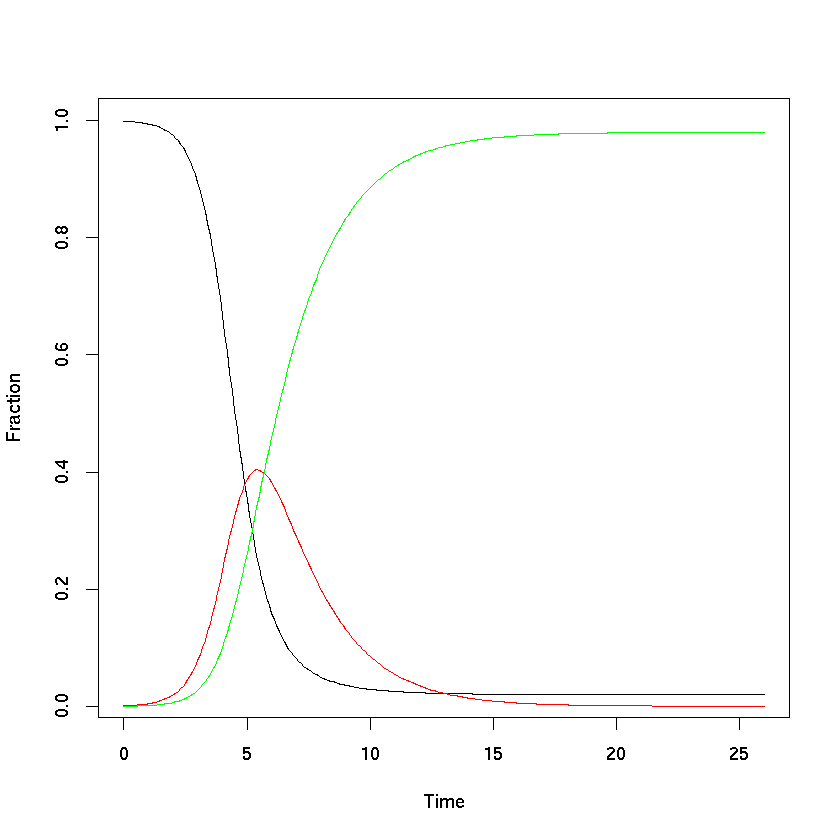

In [5]:
plot(x = out$time, y = out$S, ylab = "Fraction", 
      xlab = "Time", type = "l")
lines(x = out$time, y = out$I, col = "red")
lines(x = out$time, y = out$R, col = "green")

Calculate $R_0$.

In [6]:
R0 = parms["beta"]/(parms["gamma"]+parms["mu"])

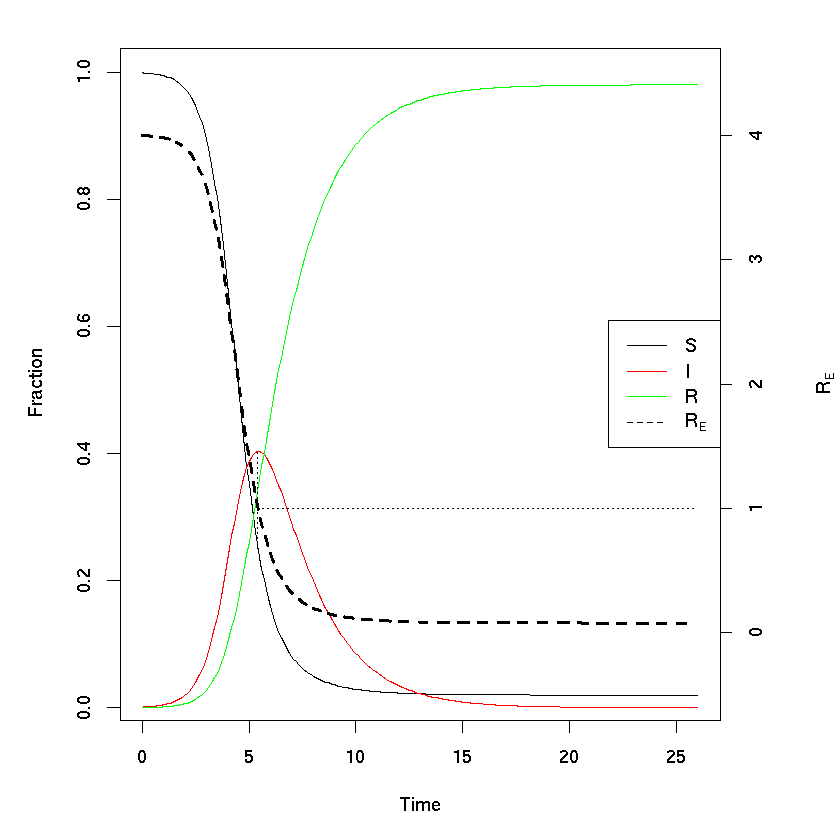

In [7]:
#Adjust margins to accommodate a second right axis
par(mar = c(5,5,2,5))
#Plot state variables
plot(x = out$time, y = out$S, ylab = "Fraction",
     xlab = "Time",  type = "l")
lines(x = out$time, y = out$I, col = "red")
lines(x = out$time, y = out$R, col = "green")

#Add vertical line at turnover point
xx = out$time[which.max(out$I)]
lines(c(xx,xx), c(1/R0,max(out$I)), lty = 3)

#prepare to superimpose 2nd plot
par(new = TRUE)
#plot effective reproductive ratio (w/o axes)
plot(x = out$time, y = R0*out$S, type = "l", lty = 2,
     lwd = 2, col = "black", axes = FALSE, xlab = NA, 
     ylab = NA, ylim = c(-.5, 4.5))
lines(c(xx, 26), c(1,1), lty = 3)
#Add right-hand axis for RE
axis(side = 4)
mtext(side = 4, line = 4, expression(R[E]))
#Add legend
legend("right", legend = c("S", "I", "R", 
     expression(R[E])), lty = c(1,1,1, 2),  
     col = c("black", "red", "green", "black"))

Find equilibrium values.

In [8]:
equil=runsteady(y=c(S=1-1E-5, I=1E-5, R=0), 
times=c(0,1E5), func=sirmod, parms=parms)
round(equil$y, 3)

S    I    R 
0.02 0.00 0.98

Candidate values for $R_0$ and $\beta$.

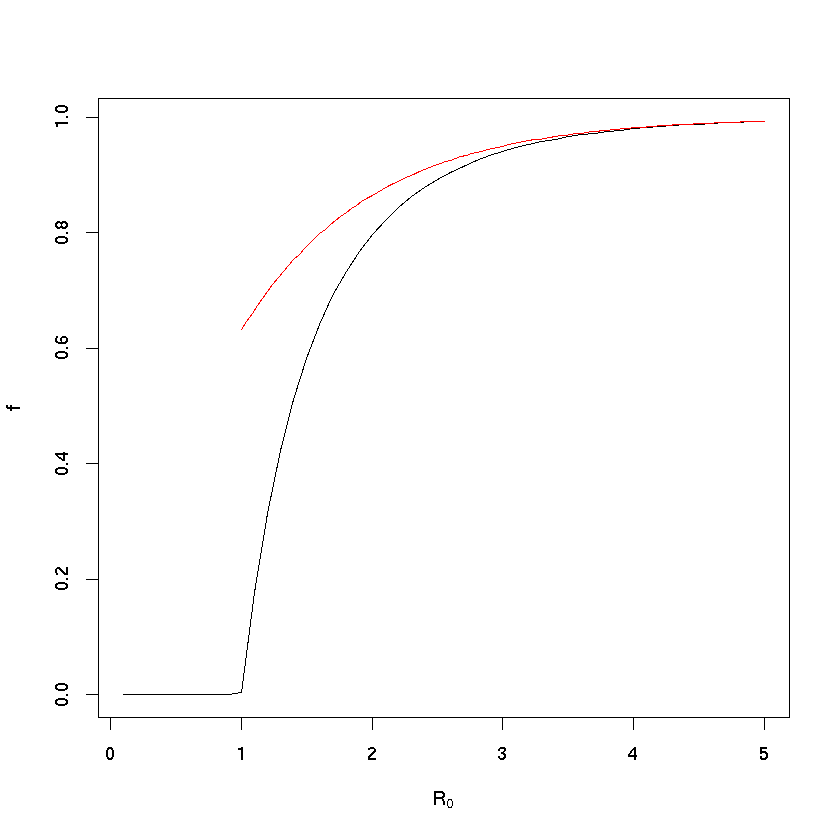

In [9]:
R0 = seq(0.1, 5, length=50)
betas= R0 * 1/2
#Vector of NAs to be filled with numbers
f = rep(NA, 50)
#Loop over i from 1, 2, ..., 50
for(i in seq(from=1, to=50, by=1)){
     equil=runsteady(y=c(S=1-1E-5, I=1E-5, 
       R=0), times=c(0,1E5), func=sirmod, 
       parms=c(mu=0, N=1, beta=betas[i], gamma=1/2))
     f[i]=equil$y["R"]
}
plot(R0, f, type="l", xlab=expression(R[0]))
curve(1-exp(-x), from=1, to=5, add=TRUE, col="red")

In [10]:
#Define function
fn=function(x, R0){
 exp(-(R0*(1-x))) - x
}
1-uniroot(fn, lower = 0, upper = 1-1E-9, 
     tol = 1e-9, R0=2)$root
#check accuracy of approximation:
exp(-2)-uniroot(fn, lower = 0, upper = 1-1E-9, 
     tol = 1e-9, R0=2)$root

[1] 0.7968121

[1] -0.06785259

Plot time series and phase plane.

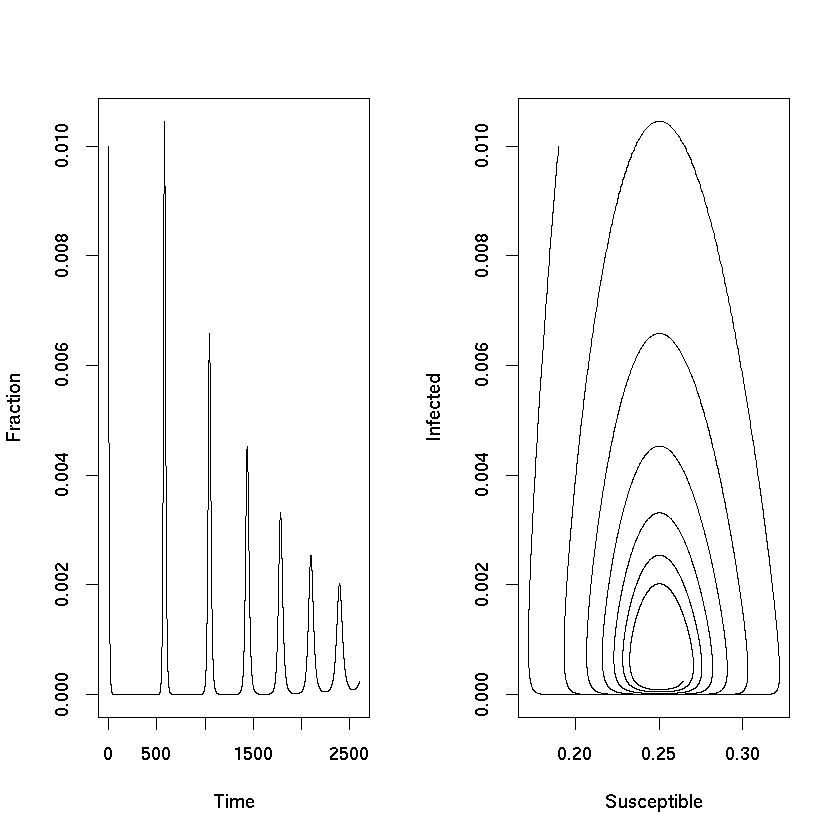

In [11]:
times  = seq(0, 52*50, by=.1)
parms  = c(mu = 1/(50*52), N = 1, beta =  2, 
      gamma = 1/2)
start = c(S=0.19, I=0.01, R = 0.8)
out = as.data.frame(ode(y=start, times=times, 
      func=sirmod, parms=parms))
par(mfrow=c(1,2)) #Make room for side-by-side plots 
plot(times, out$I, ylab="Fraction", xlab="Time", 
     type="l")
plot(out$S, out$I, type="l", xlab="Susceptible", 
      ylab="Infected")

### SI model

In [12]:
simod=function(t, y, parameters){
   S=y[1]
   I=y[2]

   beta=parameters["beta"]
   mu=parameters["mu"]
   gamma=parameters["gamma"]
   N=parameters["N"]
   
   dS = mu * (N  - S)  - beta * S * I / N
   dI = beta * S * I / N - (mu + gamma) * I
   res=c(dS, dI)
   list(res)
}

Plot vector field.

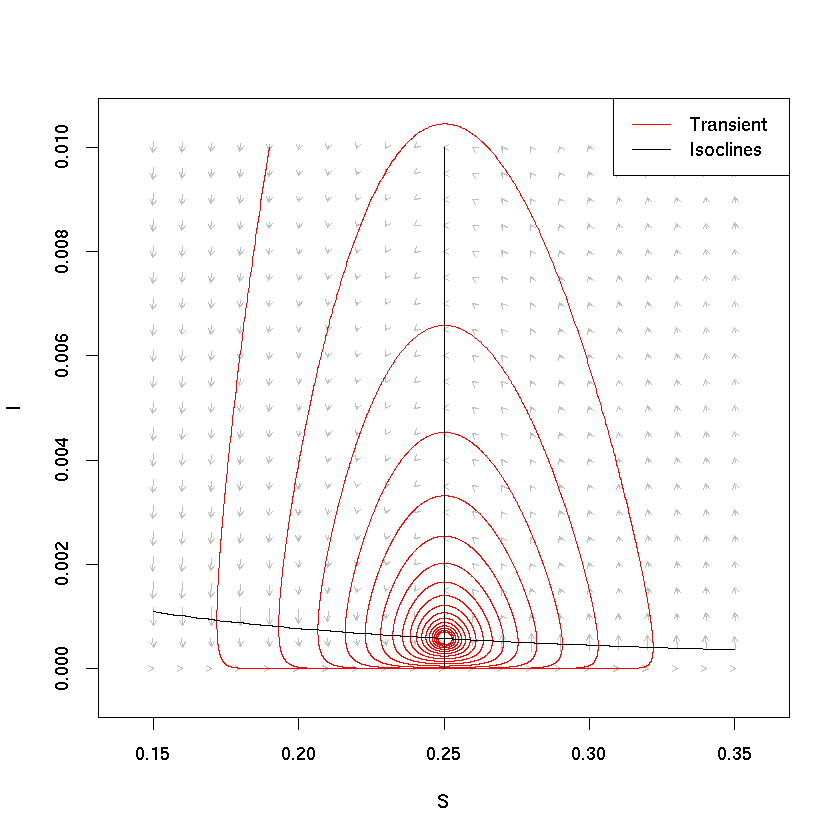

In [13]:
fld = flowField(simod, xlim = c(0.15,0.35), 
     ylim = c(0,.01), parameters = parms, system = "two.dim", 
     add = FALSE, ylab = "I", xlab = "S")
#Add trajectory
out = as.data.frame(ode(y = c(S = 0.19, I = 0.01), 
     times =  seq(0, 52*100, by = .1), func = simod, parms = parms))
 lines(out$S, out$I, col = "red")
#Add S-isocline
curve(parms["mu"]*(1/x-1)/parms["beta"], 0.15, 0.35, 
     xlab = "S", ylab = "I", add = TRUE)
#Add I-isocline
shat = (parms["gamma"] + parms["mu"])/parms["beta"]
lines(rep(shat, 2), c(0,0.01))
legend("topright", legend = c("Transient", "Isoclines"),
     lty = c(1, 1), col = c("red", "black"))

In [14]:
#Pull values from parms vector
gamma = parms["gamma"]
beta = parms["beta"]
mu = parms["mu"]  
N = parms["N"]  
#Endemic equilibrium  
Sstar=(gamma+mu)/beta
Istar=mu*(beta/(gamma+mu)-1)/beta
eq1=list(S=Sstar, I=Istar)

Define equations.

In [15]:
dS = expression(mu * (N  - S)  - beta * S * I / N)
dI = expression(beta * S * I / N - (mu + gamma) * I)

Differentiate w.r.t. S and I

In [16]:
j11 = D(dS, "S")
j12 = D(dS, "I")
j21 = D(dI, "S")
j22 = D(dI, "I")

Evaluate Jacobian at equilibrium.

In [17]:
J=with(data=eq1, expr=matrix(c(eval(j11),eval(j12),
     eval(j21),eval(j22)), nrow=2, byrow=TRUE))
#Calculate eigenvalues
eigen(J)$values

[1] -0.00076864+0.02400384i -0.00076864-0.02400384i

In [18]:
2*pi/(Im(eigen(J)$values[1]))

[1] 261.7575

In [19]:
eq2=list(S=1,I=0)
J=with(eq2, 
     matrix(c(eval(j11),eval(j12),eval(j21),
     eval(j22)), nrow=2, byrow=TRUE))
eigen(J)$values

[1]  1.4996153846 -0.0003846154

In [20]:
chainSIR = function(t, logx, params){
    x = exp(logx)
    u = params["u"]
    S = x[1]
    I = x[2:(u+1)]
    R = x[u+2]
    with(as.list(params),{
      dS = mu * (N - S)  - sum(beta * S * I) / N
      dI = rep(0, u)
      dI[1] = sum(beta * S * I) / N - (mu + u*gamma) * I[1]
      if(u>1){
         for(i in 2:u){
             dI[i] = u*gamma * I[i-1] - (mu+u*gamma)* I[i]
          }
       }
      dR = u*gamma * I[u] - mu * R
      res = c(dS/S, dI/I, dR/R)
      list(res)
})
}

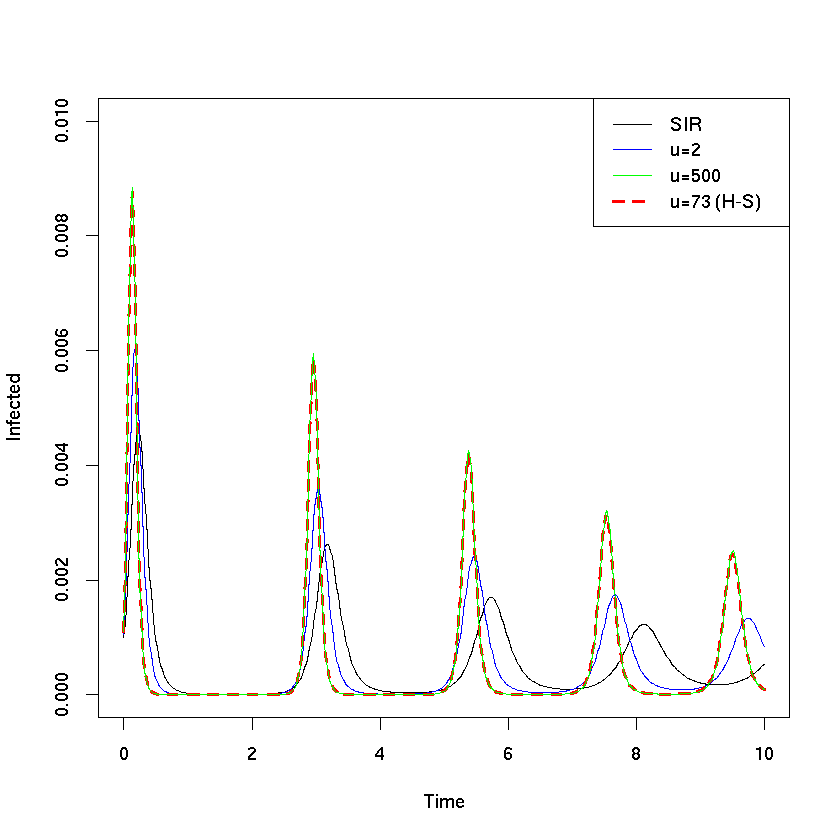

In [21]:
times = seq(0, 10, by=1/52)
paras2 = c(mu = 1/75, N = 1, beta =  625, 
     gamma = 365/14, u=1)
xstart2 = log(c(S = .06, I = c(0.001, rep(0.0001, 
     paras2["u"]-1)), R = 0.0001))
out = as.data.frame(ode(xstart2, times, chainSIR, 
     paras2))
plot(times, exp(out[,3]), ylab = "Infected", xlab =
     "Time", ylim = c(0, 0.01), type = 'l')

paras2["u"] = 2
xstart2 = log(c(S = .06, I = c(0.001, rep(0.0001/
     paras2["u"], paras2["u"]-1)), R = 0.0001))
out2 = as.data.frame(ode(xstart2, times, chainSIR, 
     paras2))
lines(times, apply(exp(out2[,-c(1:2,length(out2))]),
     1 ,sum), col = 'blue')

paras2["u"] = 73
xstart2 = log(c(S = .06, I = c(0.001, rep(0.0001/
     paras2["u"], paras2["u"]-1)), R = 0.0001))
out3 = as.data.frame(ode(xstart2, times, chainSIR, 
     paras2))
lines(times, apply(exp(out3[,-c(1:2,length(out3))]),
     1, sum), col='red', lwd=2, lty=2)

paras2["u"] = 500
xstart2 = log(c(S = .06, I = c(0.001, rep(0.0001/
     paras2["u"], paras2["u"]-1)), R = 0.0001))
out4 = as.data.frame(ode(xstart2, times, chainSIR, 
     paras2))
lines(times, apply(exp(out4[,-c(1:2,length(out4))]),
     1,sum, na.rm = TRUE), col = 'green')

legend("topright", legend = c("SIR", "u=2", "u=500", 
     "u=73 (H-S)"), lty = c(1,1,1,2), lwd = c(1,1,1, 2),
     col = c("black", "blue", "green", "red"))

In [22]:
require(shiny)
require(deSolve)
require(phaseR)

#This creates the User Interface (UI)
ui = pageWithSidebar(
#The title
headerPanel("The SIR model"),
#The sidebar for parameter input
sidebarPanel(
   #Sliders:
   sliderInput("beta", "Transmission (yr^-1):", 300,
              min = 0, max = 1000),
   sliderInput("infper", "Infectious period (days)", 5,
              min = 1, max = 100),
   sliderInput("mu", "birth rate:", 5,
              min = 0, max = 100),
   sliderInput("T", "Time range:",
                  min = 0, max = 1, value = c(0,1))
),
#Main panel for figures and equations
mainPanel(
  #Multiple tabs in main panel
  tabsetPanel(
    #Tab 1: Time plot (plot1 from server)
    tabPanel("Time", plotOutput("plot1")), 
    #Tab 2: Phase plot (plot2 from server)
    tabPanel("Phase plane", plotOutput("plot2", 
         height = 500)),
    #Tab 3: MathJax typeset equations 
    tabPanel("Equations", 
       withMathJax(
         helpText("Susceptible $$\\frac{dS}{dt} = 
            \\mu (N - S) - \\frac{\\beta I S}{N}$$"),
         helpText("Infecitous $$\\frac{dI}{dt} = 
            \\frac{\\beta I S}{N} - (\\mu+\\sigma) I$$"),
         helpText("Removed $$\\frac{dR}{dt} = 
            \\gamma I - \\mu R$$"),
         helpText("Reproductive ratio $$R_0 =  
            \\frac{1}{\\gamma+\\mu} \\frac{\\beta N}{N}$$")             
         ))
))) #End of ui()

# This creates the 'behind the scenes' code (Server)
server = function(input, output) {
  #Gradient function for SIR model
  sirmod=function(t, x, parms){
    S=x[1]
    I=x[2]
    R=x[3]
    beta=parms["beta"]
    mu=parms["mu"]
    gamma=parms["gamma"]
    N=parms["N"]
    dS = mu * (N  - S)  - beta * S * I / N
    dI = beta * S * I / N - (mu + gamma) * I
    dR = gamma * I - mu * R
    res=c(dS, dI, dR)
    list(res)
   }

  #Gradient function used for phaseR phase-plot
  simod=function(t, y, parameters){
   S=y[1]
   I=y[2]
   beta=parameters["beta"]
   mu=parameters["mu"]
   gamma=parameters["gamma"]
   N=parameters["N"]   
   dS = mu * (N  - S)  - beta * S * I / N
   dI = beta * S * I / N - (mu + gamma) * I
   res=c(dS, dI)
   list(res)
  }

  #Plot1: renderPlot to be passed to UI tab 1
  output$plot1 = renderPlot({
  #input\$xx's are pulled from UI
  times  = seq(0, input$T[2], by=1/1000)
  parms  = c(mu = input$mu, N = 1, beta =  input$beta, 
    gamma = 365/input$infper)
  start = c(S=0.999, I=0.001, R = 0)
  R0 = round(with(as.list(parms), beta/(gamma+mu)), 1)
  
  #Integrate ode with parameters pulled from UI
  out=ode(y=start, times=times, func=sirmod, 
    parms=parms)
  out=as.data.frame(out)

  #Plot1
  sel=out$time>input$T[1]&out$time<input$T[2]
  plot(x=out$time[sel], y=out$S[sel], ylab="fraction", 
    xlab="time", type="l", ylim=range(out[sel,-c(1,4)]))
  title(paste("R0=", R0))
  lines(x=out$time[sel], y=out$I[sel], col="red")
  lines(x=out$time[sel], y=out$R[sel], col="green")
  legend("right", legend=c("S", "I", "R"),
        lty=c(1,1,1), col=c("black", "red", "green"))
   })

  #Plot2: renderPlot to be passed to UI tab 2
  output$plot2 = renderPlot({
  times  = seq(0, input$T[2], by=1/1000)
  parms  = c(mu = input$mu, N = 1, beta =  input$beta, 
    gamma = 365/input$infper)
  start = c(S=0.999, I=0.001, R = 0)
  R0 = round(with(as.list(parms), beta/(gamma+mu)), 1)

  #Integrate simod
  out=ode(y=start[-3], times=times, func=simod, 
    parms=parms)
  out=as.data.frame(out)

  #Plot2
  plot(x=out$S, y=out$I, xlab="Fraction suceptible", 
    ylab="Fraction infected", type="l")
  title(paste("R0=", R0))
  #Add vector field
  fld=flowField(simod, x.lim=range(out$S), y.lim=
    range(out$I), parameters=parms, system="two.dim", 
    add=TRUE, ylab="I", xlab="S")
  #Add isoclines
  abline(v=1/R0, col="green")
  curve(parms["mu"]*(1-x)/(parms["beta"]*x), min(out$S), 
      max(out$S), add=TRUE, col="red")
  legend("topright",  legend=c("I-socline", 
      "S-isocline"), lty=c(1,1), col=c("red", "green"))
   })
  } #End of server()

shinyApp(ui, server)


Listening on http://127.0.0.1:5683
